<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Detector1 for TSO imaging

<span style="color:red"> **Instruments Affected**</span>: MIRI

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br>[Run JWST Pipeline](#pipeline_ID) <br> [Examine Input and Output Data](#examine_data)  <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction

This notebook is meant to process a data set through the Detector1 pipeline for TSO data (calwebb_tso1). The steps are as follow:

1) Read in an uncalibrated TSO imaging file.

2) Process through calwebb_detctor1 using parameters set in calwebb_tso1.cfg.

3) Test various steps and outputs from the pipeline run.

These steps are set up with an example simulated MIRI dataset.

The pipeline documentation can be found here: https://jwst-pipeline.readthedocs.io/en/latest/

The pipeline code is available on GitHub: https://github.com/spacetelescope/jwst

### Defining Terms

Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

    JWST: James Webb Space Telescope
    MIRI: Mid-Infrared Instrument
    LRS: Low Resolution Spectrometer
    TSO: Time Series Observation



<a id="imports_ID"></a>
## Imports

* jwst.datamodels for building model for JWST Pipeline
* jwst.pipeline is the pipeline being tested
* matplotlib.pyplot.plt to generate plot
* numpy for array calculations and manipulation
* pysiaf to get coordinates of MIRI apertures 
* astropy.io and download_file allow downloading and accessing files
* ci_watson and get_bigdata allow accessing files stored in artifactory

In [2]:
from astropy.io import fits, ascii
from astropy.utils.data import download_file
from ci_watson.artifactory_helpers import get_bigdata
from jwst.datamodels import RampModel, ImageModel, dqflags, CubeModel
from jwst.pipeline import Detector1Pipeline
import matplotlib.pyplot as plt
import numpy as np
import os
import pysiaf

### Read in file and update headers to have needed keywords for TSO mode


In [3]:
def checkheaders(model):
    
    # check that header has keyword TSOVISIT set to true (all TSO data should have this set)
    
    if model.meta.visit.tsovisit != True:
        model.meta.visit.tsovisit = True
        print('Setting TSOVISIT keyword')
        
    # check that CRPIX1 and CRPIX2 are set to the center of the siaf aperture for the array being used.
    # Read in array being used
    array = model.meta.subarray.name
    print(array)
    if array == 'FULL':
        siaf = pysiaf.Siaf('MIRI') 
        full = siaf['MIRIM_FULL']
        model.meta.wcsinfo.crpix1 = full.XSciRef
        model.meta.wcsinfo.crpix2 = full.YSciRef
    if array == 'SUB64':
        # subarray siaf values are not quite right in MIRISim. Need to centroid to find x and y
        # start with siaf values
        siaf = pysiaf.Siaf('MIRI')
        sub = siaf['MIRIM_SUB64']
        x_initial = sub.XSciRef - 8 # known 8 pixel shift in subarray source position
        y_initial = sub.YSciRef
        
        print(x_initial, y_initial)
        
        # Take initial estimate and centroid to find source
        center = centroids.centroid_sources(model.data[0,0,:,:], x_initial, y_initial, box_size=11)
        xcentroid = center[0][0]
        ycentroid = center[1][0]
        
        print(center[0][0], center[1][0])   
        model.meta.wcsinfo.crpix1 = xcentroid
        model.meta.wcsinfo.crpix2 = ycentroid



<a id="pipeline_ID"></a>
## Run JWST Pipeline

### Set up parameters for individual steps and run calwebb_detector1

In [4]:
# set up pipeline parameters and file names
# Input file names

# This section to download data from remote and run local
mainurl ="https://data.science.stsci.edu/redirect/JWST/TSO/pipeline_testing_miri_ima_tso/"
filename = 'pipetest_miri_imtso_FULL_10g10i_F770W.fits'
file = download_file(mainurl+filename)

# open file into correct format and write to local disk for processing
hdu = fits.open(file)
hdu.info()
hdu.writeto(filename)

satfile = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',
                     'jump_miri_test', 
                     'miri_sat_55k.fits')

readnoisefile = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',
                     'jump_miri_test', 
                     'jwst_mirisim_readnoise.fits')

tag='_b75_tso'  # string tag to distinguish different tests in output file name

# Read in data file to model    
with RampModel(filename) as model:
    # raises exception if file is not the correct model
    pass    
          

Filename: /var/folders/qq/59kq_9pn42d5fg_5wxzzwx1w0004_p/T/astropy-download-84240-ert9_07f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     108   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 10, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 10, 10)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 10, 10)   float32   
  5  REFOUT        1 ImageHDU        11   (258, 1024, 10, 10)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [5247B]   


In [5]:
# Set up cosmic ray jump testing by adding in cosmic rays
# set variables

# Choose selected pixels to put cr hits of varying fluxes in
xpos = [460, 480, 500, 520, 540, 560, 580]
ypos = [150, 150, 150, 150, 150, 150, 150]
crmags = [10, 25, 50, 100, 200, 500, 1000]

frame = 5  # frame to add cr
integration = 0  # integration to add crs
    
# loop through arrays of x, y and crmags to populate array with values
for x, y, crmag in zip(xpos, ypos, crmags):
    # add cr to ramps from point of 'frame' in ramp
    model.data[integration, frame:, y, x] = model.data[integration, frame:, y, x] + crmag    


In [6]:
# Run detector1 pipeline

# step parameters
rej_thresh=8.0  # rejection threshold for jump step (higher for simulated data)
    
# set up pipeline parameters for input
pipe1 = Detector1Pipeline()
pipe1.jump.rejection_threshold = rej_thresh
pipe1.saturation.override_saturation = satfile
pipe1.jump.override_readnoise = readnoisefile
pipe1.ramp_fit.override_readnoise = readnoisefile

# skip steps to make it like 'tso1 config file'
pipe1.ipc.skip = True
pipe1.firstframe.skip = True
pipe1.lastframe.skip = True
    
# Until MIRISim is updated, best to skip refpix step for simulated data
pipe1.refpix.skip = True

# check that header has needed keywords set
        
checkheaders(model)

nints = model.meta.exposure.nints
print('CRPIX1 = ',model.meta.wcsinfo.crpix1)
print('CRPIX2 = ',model.meta.wcsinfo.crpix2)
    
# set up output file name
base, remainder = filename.split('.')
#print(base)
outname = base+tag
print(outname)

pipe1.saturation.output_file = outname+'.fits'
pipe1.jump.output_file = outname+'.fits'    
pipe1.ramp_fit.output_file = outname+'.fits'
pipe1.output_file = outname+'.fits'
#pipe1.output_dir = '.'
            
# Run pipeline on each file
pipe1.run(model) 

print('Detector 1 steps completed.')

2020-07-29 14:58:16,975 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2020-07-29 14:58:16,977 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2020-07-29 14:58:16,980 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2020-07-29 14:58:16,983 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2020-07-29 14:58:16,986 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2020-07-29 14:58:16,989 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2020-07-29 14:58:16,992 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2020-07-29 14:58:16,996 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2020-07-29 14:58:16,999 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2020-07-29 14:58:17,002 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2020-07-29 

FULL


2020-07-29 14:58:17,335 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W.fits>,).
2020-07-29 14:58:17,351 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/cracraft/MIRI/MIRI-STSCI/jwst_validation_notebooks/jwst_validation_notebooks/caldetector1/pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init':

CRPIX1 =  693.5
CRPIX2 =  512.5
pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso


2020-07-29 14:58:22,086 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.
2020-07-29 14:58:22,130 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.
2020-07-29 14:58:22,184 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.
2020-07-29 14:58:22,236 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.
2020-07-29 14:58:22,289 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2020-07-29 14:58:22,290 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/Users/cracraft/MIRI/MIRI-STSCI/jwst_validation_notebooks/jwst_validation_notebooks/caldetector1/jwst_mirisim_readnoise.fits'.
2020-07-29 14:58:22,292 - stpipe

2020-07-29 14:58:44,145 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2020-07-29 14:58:44,393 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).
2020-07-29 14:58:44,394 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2020-07-29 14:58:44,436 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits
2020-07-29 15:10:39,418 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=10, nframes=1, groupgap=0
2020-07-29 15:10:39,422 - stpipe.Detector1

2020-07-29 15:14:31,294 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_0_ramp_fit.fits>,).
2020-07-29 15:14:31,295 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}
2020-07-29 15:14:31,603 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2020-07-29 15:14:31,604 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2020-07-29 15:14:31,609 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2020-07-29 15:14:31,740 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 1024, 1032) from p

Detector 1 steps completed.


In [7]:
print(outname)

pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso


<a id="examine_data"></a>
## Examine input and output data

### Take a look at the input data
* Look at the last frame
* plot a pixel up the ramp from the source
* plot a pixel up the ramp from the background

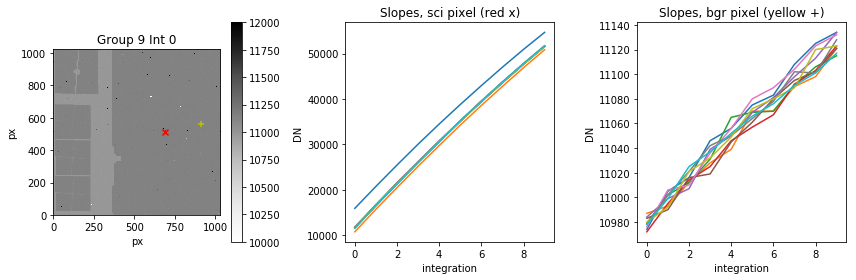

In [8]:
sci_data = model.data

ngroups = model.meta.exposure.ngroups
nints = model.meta.exposure.nints

# identify a science pixel
sci_px = [512, 692]

# identify a pixel in blank sky
bgr_px = [560, 915]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,4])

# plot 1: frame[-1] in the first integration
lastgrp = ax[0].imshow(sci_data[0,ngroups-1,:,:], origin='lower', interpolation='None', aspect='equal', cmap='Greys',
                      vmin=10000, vmax=12000)
ax[0].scatter(sci_px[1], sci_px[0], marker='x', color='r', label='sci pixel')
ax[0].scatter(bgr_px[1], bgr_px[0], marker='+', color='y', label='bgr pixel')
ax[0].set_title('Group {} Int 0'.format(ngroups-1))
ax[0].set_xlabel('px')
ax[0].set_ylabel('px')

# plot 2: pixel slope, spectrum

ax[1].set_title('Slopes, sci pixel (red x)')
for i in range(nints):
    ax[1].plot(sci_data[i, :, sci_px[0], sci_px[1]])
ax[1].set_xlabel('integration')
ax[1].set_ylabel('DN')

# plot 3: pixel slope, background

ax[2].set_title('Slopes, bgr pixel (yellow +)')
for i in range(nints):
    ax[2].plot(sci_data[i, :, bgr_px[0], bgr_px[1]])
ax[2].set_xlabel('integration')
ax[2].set_ylabel('DN')

fig.colorbar(lastgrp, ax=ax[0])
fig.tight_layout()

## Test individual output

### Test Saturation output



In [9]:
# read in file output from saturation step

with RampModel(outname+'_saturation.fits') as satmodel:
    # raises exception if file is not the correct model
    pass

data = satmodel.data
satdq = satmodel.groupdq

satvalue = 55000
print('Saturation level is: ', satvalue, ' counts.')

# Test last frame of each integration for saturation and see if it was flagged.

ngroups = model.meta.exposure.ngroups
nints = model.meta.exposure.nints

for integration in range(nints):
    # check last frame for saturation in region of star
    box = data[integration, ngroups-1 , 500:525, 680:705]
    print()
    print('Max value in 25x25 box around star position: ',np.nanmax(box))
    satframe = satdq[integration, ngroups-1, 500:525, 680:705 ]
    
    satpix = (box >= satvalue)
    #print(satpix.size)
    #print(integration,satpix)
    # if pixels greater than value, then check that they are flagged
    if satpix.any():
        print('Saturation detected in last frame of integration: ', integration)
        assert np.all(satframe[satpix] == dqflags.group['SATURATED'])
    else:
        print('No pixels saturate in last frame of integration: ', integration)

Saturation level is:  55000  counts.

Max value in 25x25 box around star position:  56628.0
Saturation detected in last frame of integration:  0

Max value in 25x25 box around star position:  52538.0
No pixels saturate in last frame of integration:  1

Max value in 25x25 box around star position:  53514.0
No pixels saturate in last frame of integration:  2

Max value in 25x25 box around star position:  53382.0
No pixels saturate in last frame of integration:  3

Max value in 25x25 box around star position:  53313.0
No pixels saturate in last frame of integration:  4

Max value in 25x25 box around star position:  53363.0
No pixels saturate in last frame of integration:  5

Max value in 25x25 box around star position:  53398.0
No pixels saturate in last frame of integration:  6

Max value in 25x25 box around star position:  53399.0
No pixels saturate in last frame of integration:  7

Max value in 25x25 box around star position:  53423.0
No pixels saturate in last frame of integration:  8

### Look at plots of output
Compare the slope image from the _rate output file to the median of the slopes of the _rateints file. They should be similar in appearance and flux levels.

Max DN/s in the rate.fits slope image: 1809.9251708984375 DN/s
Max DN/s of the median of the rateints.fits slope images: 1810.8369140625 DN/s


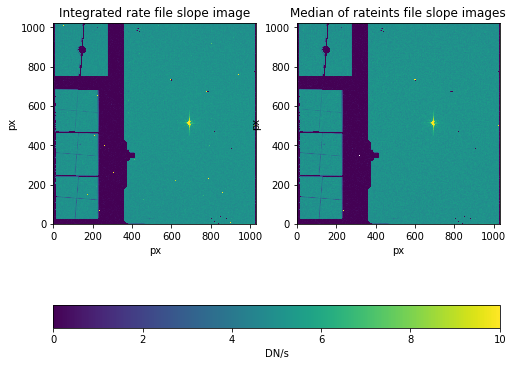

In [10]:
# this plot will compare the slope image from the _rate file with the median of the slope images in the rateints file
# check criterion: they should look similar and the maximim values seen in both these images should be similar
# NOTE: what is the numerical criterion to check for? not sure.

with ImageModel(outname+'_rate.fits') as rmod:
    # raises exception if file is not the correct model
    pass
 
with CubeModel(outname+'_rateints.fits') as rimod:
    # raises exception if file is not the correct model
    pass

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8,10])

rplt = ax[0].imshow(rmod.data, origin='lower', aspect='equal', interpolation='None', vmin=0, vmax=10)
ax[0].set_title('Integrated rate file slope image')
ax[0].set_xlabel('px')
ax[0].set_ylabel('px')

riplt = ax[1].imshow(np.median(rimod.data, axis=0), origin='lower', aspect='equal', interpolation='None',
                    vmin=0, vmax=10)
ax[1].set_title('Median of rateints file slope images')
ax[1].set_xlabel('px')
ax[1].set_ylabel('px')

cbar = fig.colorbar(rplt, ax=ax, orientation='horizontal')
cbar.set_label('DN/s')
#fig.tight_layout()

print('Max DN/s in the rate.fits slope image: {} DN/s'.format(np.max(rmod.data)))
print('Max DN/s of the median of the rateints.fits slope images: {} DN/s'.format(np.nanmax(np.median(rimod.data, axis=0))))



### Test output of jump step to see if specified pixels (and their neighbors) were flagged

In [11]:
# load jump step output file
with RampModel(outname+'_jump.fits') as jumpim:
    # raises exception if file is not the correct model
    pass

integration = 0
frame = 5

# look for cr flags in dq grpdq array in specified locations
dqframe = jumpim.groupdq[integration, frame, :, :]

# print output on which fluxes had neighbors flagged
# output should include pixel coord, average pixel value nearby, cr value, whether neighbors were flagged
print('   xpos       ypos      crmag      avgcounts  pixflagged  neighborflagged \n')
for x, y, crmag in zip(xpos, ypos, crmags):
    # check if pixel is flagged
    # set default flag
    pixflagged = False
    neighborflagged = False

    # get stats on flux values near cr hit
    avgcounts = np.mean(jumpim.data[integration, frame, y - 10: y - 5, x - 10: x - 5])

    if dqframe[y, x] & dqflags.pixel['JUMP_DET'] > 0:
        pixflagged = True
        # check neighbor pixels
        if ((dqframe[y + 1, x] & dqflags.pixel['JUMP_DET'] > 0) and
            (dqframe[y - 1, x] & dqflags.pixel['JUMP_DET'] > 0) and
            (dqframe[y, x + 1] & dqflags.pixel['JUMP_DET'] > 0) and
            (dqframe[y, x - 1] & dqflags.pixel['JUMP_DET'] > 0)):
                neighborflagged = True

    # write output
    print('{:8.0f} {:8.0f} {:10.0f} {:15.2f} {:>10} {:>10} \n'.format(x, y, crmag, avgcounts, str(pixflagged), 
                                                                      str(neighborflagged)))


   xpos       ypos      crmag      avgcounts  pixflagged  neighborflagged 

     460      150         10        10083.47      False      False 

     480      150         25        10085.05      False      False 

     500      150         50        10084.38      False      False 

     520      150        100        10082.85       True      False 

     540      150        200        10082.94       True       True 

     560      150        500        10082.54       True       True 

     580      150       1000        10083.47       True       True 



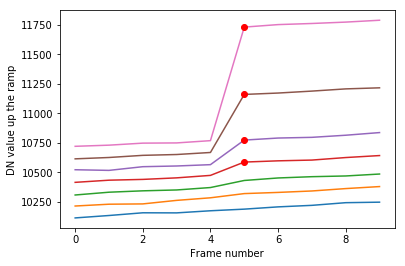

In [12]:
# plot data to see what is being flagged
i=10
nframes = model.meta.exposure.ngroups
frames = np.arange(nframes)

# set up titles for plot
plt.xlabel('Frame number')
plt.ylabel('DN value up the ramp')

for x, y in zip(xpos, ypos):
    # get locations of flagged pixels within the ramps
    jumps = jumpim.groupdq[integration, :, y, x] & dqflags.pixel['JUMP_DET'] > 0
    #print(jumps)
    ramp = jumpim.data[integration, :, y, x]

    # plot ramps of selected pixels and flagged jumps
    plt.plot(ramp+i*10)
    plt.plot(frames[jumps], ramp[jumps]+i*10, color='r', marker='o')
    i = i+10

#plt.legend()
plt.show()

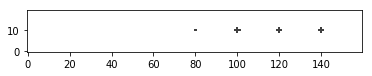

In [13]:
# show region of dq array to see if cross pixels were flagged 
data = jumpim.groupdq[integration, frame, 140:160, 440:600]
plt.imshow(data, cmap='Greys', origin='lower', vmin=0,vmax=5)
plt.show()

<a id="about_ID"></a>
## About this Notebook
**Author:** Misty Cracraft, Senior Staff Scientist, MIRI Branch
<br>**Updated On:** 07/28/2020